In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import random

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import pandas as pd
import geopandas as gpd
import contextily as ctx
import shapely.wkt
from shapely.geometry import Polygon
import libpysal
import esda
import rasterio 
from rasterio.transform import Affine

In [2]:
## Helper functions

def round_down(num, divisor):
    return np.floor(num / divisor) * divisor

def round_up(num, divisor):
    return np.ceil(num / divisor) * divisor  

def save_raster(data, outname, dtype, grid_cols, grid_rows, gridSize):
    
    transform = rasterio.transform.from_origin(grid_cols[0], grid_rows[0], gridSize, gridSize)

    meta = {'driver' :'GTiff', 
            'width' : len(grid_cols), 
            'height' : len(grid_rows),
            'count' : 1, 
            'dtype' : dtype, 
            'crs' : rasterio.crs.CRS.from_epsg(3857),
            'transform' : transform,
           }
    
    new_dataset = rasterio.open(
        outname,
        'w',
        **meta,
    )
    new_dataset.write(data, 1)
    new_dataset.close()

In [3]:
filepattern = "hamm_KWall" 
# "hamm_complete", "hamm_reduced", "hamm_KWall", "hamm_KW26/27/28/29/30/31/32/33/34"
kg_km = True

In [4]:
# Get filename
filepath = "data/hamm/enviroCar/"

for file in os.listdir(filepath):
    if re.search(filepattern, file) != None:
        filename_in = os.path.join(filepath, file)
        print(filename_in)
        break

if kg_km:
    filepattern = filepattern + "_kgkm" 
else:
    filepattern = filepattern + "_kgh" 
        
# Read from file
columns = ['track.id','time','geometry','CO2.value','Speed.value']
track_df_pd = pd.read_csv(filename_in, usecols=columns)
# Convert to Geopandas dataframe
geometry = track_df_pd['geometry'].map(shapely.wkt.loads)
track_df_pd = track_df_pd.drop('geometry', axis=1)
track_df = gpd.GeoDataFrame(track_df_pd, crs="EPSG:4326", geometry=geometry)
track_df = track_df.to_crs(epsg=3857)
# Optionally convert CO2 values from kg/h to kg/km
if kg_km:
    track_df = track_df.dropna(subset=['Speed.value'])
    track_df = track_df[track_df['Speed.value']!=0]
    track_df['CO2.value'] = track_df['CO2.value']/track_df['Speed.value'] 

track_df.head()

data/hamm/enviroCar/hamm_KWall_2020-08-25_17:04:29_3000tracks.csv


,track.id,time,CO2.value,Speed.value,geometry
11,5f3fba5105fa792e88fd7126,2020-08-21T12:03:01,0.428713,10.057627,POINT (869626.958 6742601.218)
12,5f3fba5105fa792e88fd7126,2020-08-21T12:03:06,0.717141,7.000000,POINT (869639.233 6742614.670)
14,5f3fba5105fa792e88fd7126,2020-08-21T12:03:16,0.986516,15.585492,POINT (869648.093 6742624.014)
15,5f3fba5105fa792e88fd7126,2020-08-21T12:03:21,0.300843,36.140823,POINT (869625.275 6742669.309)
16,5f3fba5105fa792e88fd7126,2020-08-21T12:03:27,0.130380,35.469044,POINT (869570.018 6742738.426)


In [109]:
# Cut beginning and ending of each track

#track_df_cut = track_df.iloc[0:0]

#for id in track_df['track.id'].unique():
#    track_df_cut = track_df_cut.append(track_df[track_df['track.id'] == id][10:-10], ignore_index=True)
    
#track_df = track_df_cut

# Grid

In [5]:
##  Create grid

#gridSize = 0.00025 # in degree
gridSize = 30 # in m
xmin,ymin,xmax,ymax = track_df.total_bounds
height, width = gridSize, gridSize

grid_cols = list(np.arange(round_down(xmin,gridSize), round_up(xmax,gridSize), gridSize))
grid_rows = list(np.arange(round_down(ymin,gridSize), round_up(ymax,gridSize), gridSize))
grid_rows.reverse()

polygons = []
for x in grid_cols:
    for y in grid_rows:
        polygons.append( Polygon([(x,y), (x+width, y), (x+width, y-height), (x, y-height)]) )

grid_gdf = gpd.GeoDataFrame({'geometry':polygons})
grid_gdf.crs = track_df.crs

grid_gdf.head()

#grid_gdf.to_csv("data/hamm/grid.csv")
#grid_gdf.to_file("data/hamm/grid/grid.shp")

,geometry
0,"POLYGON ((859380.000 6747840.000, 859410.000 6..."
1,"POLYGON ((859380.000 6747810.000, 859410.000 6..."
2,"POLYGON ((859380.000 6747780.000, 859410.000 6..."
3,"POLYGON ((859380.000 6747750.000, 859410.000 6..."
4,"POLYGON ((859380.000 6747720.000, 859410.000 6..."


In [6]:
## Spatial join of grid and track

field = 'CO2.value'
summary = 'mean'

# Assign grid id
grid_gdf['gridId']=list(range(len(grid_gdf)))
    
# Identify grid id for each point
grid_joined = gpd.sjoin(track_df, grid_gdf, op='within')
    
# Group points by grid id and calculate mean
grouped = grid_joined.groupby('gridId')[field]
#pd.DataFrame(grouped).to_csv("data/hamm/grouped.csv")
grouped = grouped.agg(summary)
grouped_df = pd.DataFrame(grouped)

# Add mean CO2 values to grid
co2_grid = grid_gdf.join(grouped_df, on='gridId').fillna(0)
co2_grid['x_centroid'],co2_grid['y_centroid'] = co2_grid.geometry.centroid.x,co2_grid.geometry.centroid.y

#grid_gdf.to_csv("data/hamm/grid_gdf.csv")
#grid_joined.to_csv("data/hamm/grid_joined.csv")
#grouped_df.to_csv("data/hamm/grouped_df.csv")
#co2_grid.to_csv("data/hamm/co2_grid.csv")

225522
10808


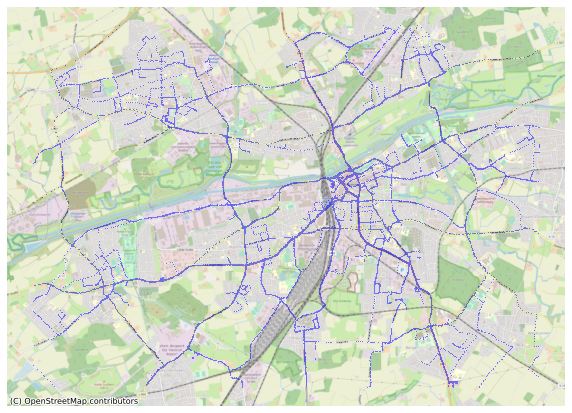

In [7]:
## Plot grid cells which contain CO2 values

print(len(co2_grid))
print(len(co2_grid[co2_grid[field]>0]))

ax = co2_grid[co2_grid[field]>0].plot(figsize=(10,10), alpha=0.5,color='b')
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
# Basemaps:
# https://github.com/geopandas/contextily/blob/master/contextily/_providers.py
# source=ctx.providers.Stamen.TonerLite
# source=ctx.providers.OpenStreetMap.DE 

# Hotspot analysis

In [8]:
# Calculate weights

threshold = 300 # 300 / 30 (gridSize) = 10 (cells)

# Remove unrealistic values
if kg_km:
    co2_hotspot = co2_grid[co2_grid['CO2.value']>0.01]
    co2_hotspot = co2_hotspot[co2_hotspot['CO2.value']<2]
else:
    co2_hotspot = co2_grid[co2_grid['CO2.value']>0.25]
    co2_hotspot = co2_hotspot[co2_hotspot['CO2.value']<50]
    
coords = [(x,y) for x,y in zip(co2_hotspot['x_centroid'], co2_hotspot['y_centroid'])]
#print(len(coords))
#print(coords)

w = libpysal.weights.DistanceBand(coords, threshold, binary=True)
# binary: If true w_{ij}=1 if d_{i,j}<=threshold, otherwise w_{i,j}=0
#         If false wij=dij^{alpha}
#         default: binary=True
# alpha: distance decay parameter for weight (default -1.0)
# distance_metric: metric of distance (default: distance_metric='euclidean'), alternative: distance_metric='arc' (automatically if radius != None)
# radius: If supplied arc_distances will be calculated based on the given radius, usually earth radius in km pysal.cg.RADIUS_EARTH_KM

w.set_transform('R') # to apply a row-standardization of weights (= division by row sum)

#print(len(w.weights))
#print(w.weights)

/home/martin/.local/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [9]:
# Calculate local Getis Ord statistic

getisOrdLocal = esda.getisord.G_Local(co2_hotspot['CO2.value'], w, transform='R', star=True)
# transform: 'B' (binary) or 'R' (row-standardized), given weights are accordingly converted internally and reconverted to original after finishing
# star: whether or not to include focal observation in sums (default: False)

#co2_hotspot = co2_grid
co2_hotspot = co2_hotspot.assign(z_score = getisOrdLocal.Zs)
co2_hotspot = co2_hotspot.assign(p_value = getisOrdLocal.p_norm)

#co2_hotspot.to_csv("data/hamm/co2_hotspot.csv")

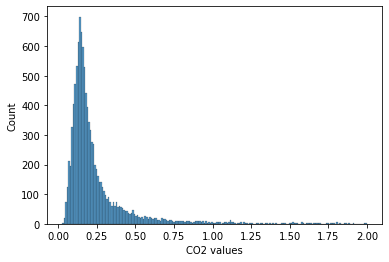

In [10]:
# Histogram of CO2 values
sns_plot = sns.histplot(co2_hotspot['CO2.value'], bins=200);
sns_plot.set_xlabel("CO2 values");
sns_plot.figure.savefig('data/hamm/images/histogram/histogram_co2_' + filepattern + '.png')

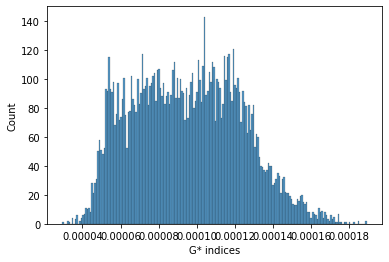

In [11]:
# Histogram of Getis Ord statistic
sns_plot = sns.histplot(getisOrdLocal.Gs, bins=200);
sns_plot.set_xlabel("G* indices");
sns_plot.figure.savefig('data/hamm/images/histogram/histogram_G_' + filepattern + '.png')

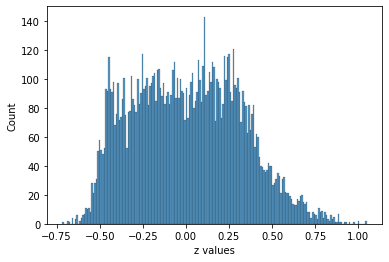

In [12]:
# Histogram of z values
sns_plot = sns.histplot(getisOrdLocal.Zs, bins=200);
sns_plot.set_xlabel("z values");
sns_plot.figure.savefig('data/hamm/images/histogram/histogram_z_' + filepattern + '.png')

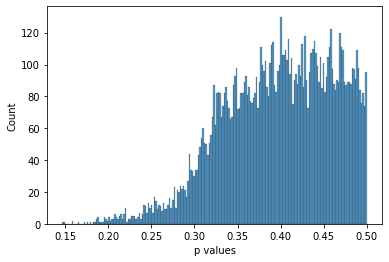

In [13]:
# Histogram of p values
sns_plot = sns.histplot(getisOrdLocal.p_norm, bins=200);
sns_plot.set_xlabel("p values");
sns_plot.figure.savefig('data/hamm/images/histogram/histogram_p_' + filepattern + '.png')

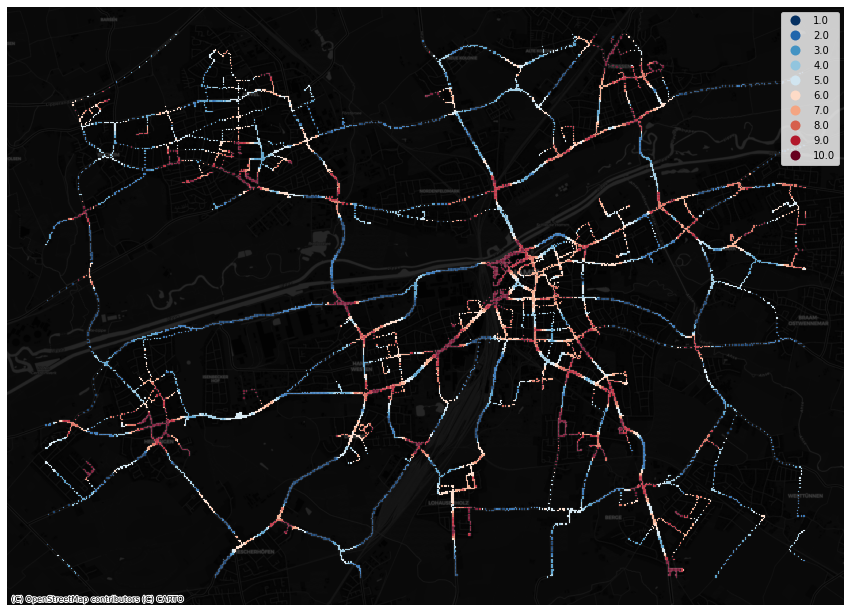

In [47]:
# Create hotspot index with levels corresponding to quantiles in steps of 10 %

quantiles = np.quantile(co2_hotspot['z_score'], np.linspace(0,1.0,11))
spots = np.empty([len(co2_hotspot),10])

hex_colors = ['#67001F','#B2182B','#D6604D','#F4A582','#FDDBC7','#D1E5F0','#92C5DE','#4393C3','#2166AC','#053061']
hex_colors.reverse()
cmap_steps = colors.ListedColormap(hex_colors)

for i in range(0,len(quantiles)-1):
    spots[:,i] = (co2_hotspot['z_score']>quantiles[i]) & (co2_hotspot['z_score']<quantiles[i+1]) 

hotspot_index_steps = 1 + spots[:,0]*0 + spots[:,1]*1 + spots[:,2]*2 + spots[:,3]*3 + spots[:,4]*4 + \
                         spots[:,5]*5 + spots[:,6]*6 + spots[:,7]*7 + spots[:,8]*8 + spots[:,9]*9 

co2_hotspot = co2_hotspot.assign(hotspot_index_steps = hotspot_index_steps)   
f, ax = plt.subplots(1, figsize=(15, 15))
co2_hotspot.plot(column='hotspot_index_steps', categorical=True, \
        k=2, cmap=cmap_steps,linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)
ax.set_axis_off();
plt.show()

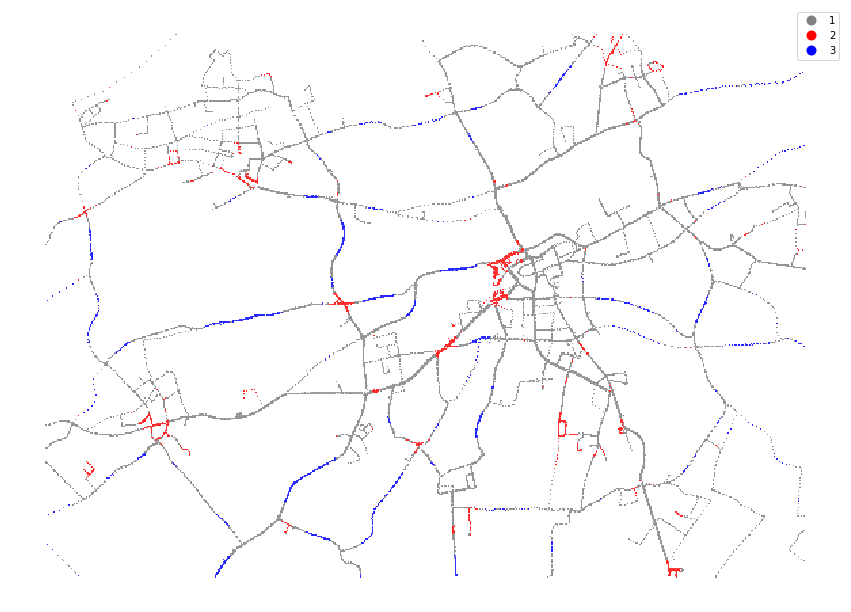

In [48]:
## Plot hotspots/coldspots

# https://pro.arcgis.com/de/pro-app/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm
# 0.1 / 1.65, 0.05 / 1.96, 0.01 / 2.58
#significance_lvl = 0.01
#critical_lvl = 2.58

quant_z_up = 0.9
quant_z_low = quant_p = 0.1

hcmap = colors.ListedColormap(['grey','red','blue'])

# Theoretical criteria
#significant = co2_hotspot['p_value'] < significance_lvl
#hotspots = (co2_hotspot['z_score']>critical_lvl) & significant
#coldspots = (co2_hotspot['z_score']<(-critical_lvl)) & significant

# Empirical criteria
significant = co2_hotspot['p_value'] < np.quantile(co2_hotspot['p_value'], quant_p)
hotspots = (co2_hotspot['z_score']>np.quantile(co2_hotspot['z_score'], quant_z_up)) 
coldspots = (co2_hotspot['z_score']<np.quantile(co2_hotspot['z_score'], quant_z_low)) 

co2_hotspot = co2_hotspot.assign(significant = significant)
co2_hotspot = co2_hotspot.assign(hotspots = hotspots)
co2_hotspot = co2_hotspot.assign(coldspots = coldspots)

# 1=hotcold spot, 2=hotspot, 3=coldspot
hotspot_index = 1 + hotspots*1 + coldspots*2
co2_hotspot = co2_hotspot.assign(hotspot_index = hotspot_index)
hcmap = colors.ListedColormap(['grey','red','blue'])
f, ax = plt.subplots(1, figsize=(15, 15))
co2_hotspot.plot(column='hotspot_index', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

#co2_hotspot.to_csv("data/hamm/co2_hotspot.csv")

In [49]:
# Size of grid
print(len(grid_cols))
print(len(grid_rows))

561
402


# Save as geotiff

In [50]:
## Save z and p values and hotspot index in geotiff
# nan are automatically added in the geotiff if no data is available for a specific grid cell

drop = ['geometry','x_centroid','y_centroid','significant','hotspots','coldspots','CO2.value']
temp = co2_hotspot.drop(drop, axis=1)
results = grid_gdf.join(temp.set_index('gridId'), on='gridId')
#results.to_csv("data/hamm/results/results_" + filepattern + ".csv")

z_values = results["z_score"]
z_values = np.array(z_values).reshape(len(grid_rows), len(grid_cols), order='F') # order: set fast/slow direction
p_values = results["p_value"]
p_values = np.array(p_values).reshape(len(grid_rows), len(grid_cols), order='F') # order: set fast/slow direction
hotspot_index = results["hotspot_index"]
hotspot_index = np.array(hotspot_index).reshape(len(grid_rows), len(grid_cols), order='F') # order: set fast/slow direction
hotspot_index = hotspot_index.astype('int8') 
hotspot_index_steps = results["hotspot_index_steps"]
hotspot_index_steps = np.array(hotspot_index_steps).reshape(len(grid_rows), len(grid_cols), order='F') # order: set fast/slow direction
hotspot_index_steps = hotspot_index_steps.astype('int8') 

save_raster(z_values, 'data/hamm/images/z_values_' + filepattern + '.tif', 'float64', grid_cols, grid_rows, gridSize)
save_raster(p_values, 'data/hamm/images/p_values_' + filepattern + '.tif', 'float64', grid_cols, grid_rows, gridSize)
save_raster(hotspot_index, 'data/hamm/images/hotspot_index_' + filepattern + '.tif', np.dtype(np.int8) ,grid_cols, grid_rows, gridSize)
save_raster(hotspot_index_steps, 'data/hamm/images/hotspot_index_steps_' + filepattern + '.tif', np.dtype(np.int8) ,grid_cols, grid_rows, gridSize)

In [52]:
## Save CO2 values in geotiff

co2_values = co2_grid["CO2.value"]
co2_values = np.array(co2_values).reshape(len(grid_rows), len(grid_cols), order='F') # order: set fast/slow direction

save_raster(co2_values, 'data/hamm/images/co2_values_' + filepattern + '.tif', co2_values.dtype, grid_cols, grid_rows, gridSize)